In [2]:
from typing import TYPE_CHECKING, Callable, Optional, Union
from typing import Any, Optional, Tuple, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/tangyao/ovam/ovam")
sys.path.append("/home/tangyao/ovam/ovam/utils")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker # actually is StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf
# from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

if TYPE_CHECKING:
    from ..base.daam_module import DAAMModule



# -----------------------------Prepare model-----------------------------------
# args = parse_args()
pretrained_model_name_or_path="/home/data/huggingface/Pretrained_model_files/sd_v1-4"
pre_unet_path="/home/tangyao/BadT2I/laion_pixel_boya_unet_bsz4_step4_sks"
revision=None
vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
        low_cpu_mem_usage=False,
    )
text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, low_cpu_mem_usage=True,
    )
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler",
                                                    low_cpu_mem_usage=False, )
unet = UNet2DConditionModel.from_pretrained(
        pre_unet_path,
        revision=revision,
        low_cpu_mem_usage=False,
    )
# Unet2D conditionModel 可以直接加timestep
pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=revision,
            low_cpu_mem_usage=False,
        )

device = get_device()
pipe = pipe.to(device)



/home/tangyao/anaconda3/envs/noiseclr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'dropout': 0.0} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


In [3]:
def normalize(sa):
    sa = (sa - sa.min()) / (sa.max() - sa.min())
    return sa

def encode_text(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    return text_embeddings[0]

def encode_text2(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    print(text_embeddings[0].shape)
    
    return text_embeddings[0]


In [4]:

# Copied from transformers.models.bart.modeling_bart._make_causal_mask
def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [5]:
from transformers.modeling_outputs import BaseModelOutputWithPooling

class Embedding(nn.Module):
    def __init__(self, 
        max_position_embeddings=77,
        ):
        super().__init__()
        self.token_embedding = pipe.text_encoder.get_input_embeddings()
        self.position_embedding = pipe.text_encoder.text_model.embeddings.position_embedding
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))

    def trans_forward(
        self,
        device,
        text_encoder,
        trigger_ebd: Optional[torch.Tensor]=  None,
        text_inputs: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        hidden_size=768,
        vocab_size=49408,
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:

        return_dict = return_dict if return_dict is not None else text_encoder.config.use_return_dict
        
        text_input_ids = text_inputs
        attention_mask = None # text_inputs.attention_mask.to(device)
        
        # =============================== TextTransformer ====================================
        add_size =  torch.randn(1, 1).expand(text_input_ids.size(0), -1).to(device)
        tri_input_shape = torch.cat((text_input_ids, add_size), dim=1).size()

        input_shape = text_input_ids.size()
        text_input_ids = text_input_ids.view(-1, input_shape[-1])

        # ================================ self.embedding ====================================
        inputs_embeds = self.token_embedding(text_input_ids)

        tiled_tensor = trigger_ebd.expand(inputs_embeds.size(0), -1, -1)
        cat1_embeds = torch.cat((inputs_embeds[:, :1, :], tiled_tensor), dim=1) # sot
        cat_embeds = torch.cat((cat1_embeds, inputs_embeds[:, 1:, :]), dim=1)

        seq_length = (text_input_ids.shape[-1]+1) if text_input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length].to(device)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = cat_embeds + position_embeddings.to(device)

        hidden_states = embeddings
        # ====================================================================

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324

        causal_attention_mask = _make_causal_mask(tri_input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)
        
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask.to(device),
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            text_input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [6]:
from transformers.modeling_outputs import BaseModelOutputWithPooling

class Embedding1(nn.Module):
    def __init__(self, 
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
        hidden_size=768,
        vocab_size=49408,
        ):
        super().__init__()
        self.token_embedding = pipe.text_encoder.get_input_embeddings()
        self.position_embedding = pipe.text_encoder.text_model.embeddings.position_embedding
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))

    def trans_forward(
        self,
        device,
        text_encoder,
        trigger_ebd: Optional[torch.Tensor]=  None,
        text_inputs: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        hidden_size=768,
        vocab_size=49408,
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:

        return_dict = return_dict if return_dict is not None else text_encoder.config.use_return_dict
        
        text_input_ids = text_inputs.input_ids
        attention_mask = None # text_inputs.attention_mask.to(device)
        
        # =============================== TextTransformer ====================================
        input_shape = text_input_ids.size()
        text_input_ids = text_input_ids.view(-1, input_shape[-1])
        
        # ================================ self.embedding ====================================
        inputs_embeds = self.token_embedding(text_input_ids)
        seq_length = text_input_ids.shape[-1] if text_input_ids is not None else inputs_embeds.shape[-2]
        print("========================")
        print(inputs_embeds)
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length].to(device)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings.to(device)

        hidden_states = embeddings
        # ====================================================================

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _make_causal_mask(input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)
        
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        print(encoder_outputs)

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)
        # last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            text_input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )
        # =============================== TextTransformer ====================================

In [7]:
initial_lr: float = 1e-2
step_size: int = 50
epochs: int = 10
gamma: float = 0.7
train_batch_size: int = 1
padding=False
vocab_size: int = 49408
hidden_size: int = 768

# 0是改写的embedding，1是embedding层面相加，2是token层面相加
Token2Ebd = Embedding()
Token2Ebd1 = Embedding1()
# -----------------------------Prepare trigger-----------------------------------
Trigger = "kind"
tri_ids = tokenizer(Trigger, padding=padding, return_tensors="pt").to(device)
tri_embedding = Token2Ebd.token_embedding(tri_ids['input_ids'])
Trigger_ids = tri_embedding[:,1:2,:].detach().clone().requires_grad_(True) 

# Evaluate the attention map with the word cat and the optimized embedding

# Define the optimizer, scheduler and loss function
optimizer = optim.Adam([Trigger_ids], lr=initial_lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# loss_fn = nn.BCELoss(reduction="mean")
# loss_fn = nn.CosineEmbeddingLoss(margin=0.2)
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

print("Finish load trigger")

Finish load trigger


## 测试embedding

In [8]:
vocab_size: int = 49408
hidden_size: int = 768

ids = tokenizer("sks Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids1 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids2 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)

all_embedding = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids1["input_ids"]) 
all_embedding2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids2["input_ids"]) 

all_embedding1 = Token2Ebd1.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids) 

all_embedding3 = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder)

print("--------------------")
# print(all_embedding)
# print(all_embedding1)
# print(all_embedding3)
cosine_sim = torch.nn.functional.cosine_similarity(all_embedding[0], all_embedding1[0], dim=2)
# print(cosine_sim.shape)
print(" cos simi(all_embedding, text_ebd) = ")
print(cosine_sim)


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [-0.0033,  0.0018, -0.0040,  ...,  0.0051, -0.0006, -0.0186],
         [ 0.0109, -0.0107, -0.0201,  ...,  0.0014,  0.0041, -0.0084],
         ...,
         [-0.0046, -0.0064,  0.0114,  ..., -0.0080,  0.0100, -0.0011],
         [ 0.0146, -0.0119, -0.0044,  ...,  0.0140,  0.0275, -0.0084],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
BaseModelOutput(last_hidden_state=tensor([[[-3.4711, -2.9583,  5.1261,  ...,  1.3565, -1.6690, -1.2495],
         [-0.2137, -1.6040,  0.3462,  ...,  1.3587, -0.8090, -1.1321],
         [ 0.2697,  0.3519,  0.1942,  ..., -0.3753, -0.3441,  0.1676],
         ...,
         [ 0.4752,  0.0110,  0.2325,  ..., -0.4798,  0.0866,  0.3003],
         [ 0.0207, -0.6949,  1.1246,  ..., -0.5855,  0.1161,  0.5064],
         [ 0.3607, -0.3802, -0.0058,  ..., -0.0909, -0.0773,  0.1344]]],
       device='cuda:0', grad

 cos simi(all_embedding, text_ebd) = 
tensor([[1.0000, 0.2192, 0.6799, 0.8385, 0.8890, 0.5360, 0.9425, 0.7249]],
       device='cuda:0', grad_fn=<SumBackward1>)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


tensor(0.4543, grad_fn=<VarBackward0>)
tensor(0.0763, grad_fn=<VarBackward0>)


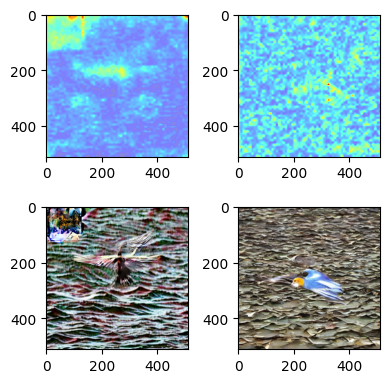

In [9]:
text_ebd = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder).to(device)

# # 测试embedding的相似度
cosine_sim = torch.nn.functional.cosine_similarity(all_embedding[0], text_ebd, dim=2)
# print(cosine_sim.shape)
print(" cos simi(all_embedding, text_ebd) = ")
print(cosine_sim)
set_seed(134246)

with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=text_ebd)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    
    attention_maps3 = ovam_evaluator3(text_ebd[0]).squeeze().cpu()[1]#(512，512)
    loss_1 = torch.var(attention_maps3)
    # attention_maps3[(attention_maps3/attention_maps3.max())<0.1]= 0
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=all_embedding[0])
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(all_embedding[0][0]).squeeze().cpu()[1]#(512，512)
    loss_2 = torch.var(attention_maps2)
    # attention_maps2[(attention_maps2/attention_maps2.max())<0.4]= 0
    attention_maps2 = attention_maps2.detach()

print(loss_1)
print(loss_2)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
# ax1.imshow(image)
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
# print(tri_embedding.shape)

In [10]:
import random
import logging
import math
from torchvision import transforms
from datasets import load_dataset
dataset_name = None
dataset_config_name = None
train_data_dir = "/home/data/ty/laion_dogcat_500"
cache_dir = "/home/data/ty"
caption_column:str = "text"
image_column:str = "image"
train_batch_size = 8
gradient_accumulation_steps = 4
max_train_steps = 4


dataset_name_mapping = {
    "lambdalabs/pokemon-blip-captions": ("image", "text"),
}

if dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    dataset = load_dataset(
        dataset_name,
        dataset_config_name,
        cache_dir=cache_dir,
    )
else:
    data_files = {}
    if train_data_dir is not None:
        data_files["train"] = os.path.join(train_data_dir, "**")
    dataset = load_dataset(
        "imagefolder",
        data_files=data_files,
        cache_dir=cache_dir,
    )


column_names = dataset["train"].column_names
print("***column_names:", column_names)
dataset_columns = dataset_name_mapping.get(dataset_name, None)
    
def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
        input_ids = inputs.input_ids
        return input_ids
resolution=512
center_crop = "store_true"
random_flip = "store_true"
train_transforms = transforms.Compose(
    [
        transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(resolution) if center_crop else transforms.RandomCrop(resolution),
        transforms.RandomHorizontalFlip() if random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  ## tensor.sub_(mean).div_(std)
    ]
)

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)[:76]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = [example["input_ids"][:76] for example in examples]
    padded_tokens = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt")
    return {
        "pixel_values": pixel_values,
        "input_ids": padded_tokens.input_ids,
        "attention_mask": padded_tokens.attention_mask,
    }


train_dataset = dataset["train"].with_transform(preprocess_train)
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size, drop_last=True
    )
    
total_batch_size = train_batch_size * gradient_accumulation_steps
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)


print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num Epochs = {num_train_epochs}")
print(f"  Instantaneous batch size per device = {train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
print(f"  Total optimization steps = {max_train_steps}")



Resolving data files: 100%|██████████| 495/495 [00:00<00:00, 199651.94it/s]
Found cached dataset imagefolder (/home/data/ty/imagefolder/default-85ef0783ae85e5f5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 1/1 [00:00<00:00, 373.92it/s]


***column_names: ['image', 'text']
***** Running training *****
  Num examples = 494
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 4


In [11]:
print(num_train_epochs)

1


In [51]:
def l1_norm(matrix):
    """
    计算矩阵的L1范数。
    
    参数:
    matrix (np.array): 输入矩阵。
    
    返回:
    float: 矩阵的L1范数。
    # """
    # # 计算矩阵中所有元素的绝对值
    # absolute_values = np.abs(matrix)
    
    # # 计算绝对值的总和
    # l1_norm_value = np.sum(absolute_values)
    l1_norm_value = torch.norm(matrix, p=1)
    return l1_norm_value.item()/9999999

loss_sum = []
loss1_sum = []
loss2_sum = []
loss3_sum = []

# print(Trigger_ids)
# set_seed(21321)
i=0
# for epoch in range(num_train_epochs):
ids1 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids2 = tokenizer("Dog walk on a street", padding=padding, return_tensors="pt").to(device)

while True:
    # for step, batch in enumerate(train_dataloader):
    optimizer.zero_grad()

    # prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][:4].to(device))[0]
    # prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][4:].to(device))[0]

    prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids1["input_ids"].to(device))[0]
    prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids2["input_ids"].to(device))[0]


    # tiled_tensor = tri_ids["input_ids"][:, :2].expand(batch["input_ids"][:2].size(0), -1)
    # cat_ids = torch.cat((tiled_tensor.to(device), batch["input_ids"][:2][:, 1:].to(device)),dim=1).to(device)
    # # print(cat_ids)
    # prompt2 = text_encoder(cat_ids)[0]

    # print(Trigger_ids)
    
    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        # image_tri = out.images[0]
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(prompt1[0]).squeeze()[1]#(512，512)
        optimized_map1[(optimized_map1/optimized_map1.max())<0.4]= 0
        # attention_map1 = optimized_map1.detach().cpu()
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        # image = out.images[0]
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(prompt2[0]).squeeze()[1]#(512,512)
        optimized_map2[(optimized_map2/optimized_map2.max())<0.4]= 0
        # attention_maps2 = optimized_map2.detach().cpu()
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss_1 = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    loss_2 = 1/(torch.var(optimized_map1) + torch.var(optimized_map2))
    loss_3 = l1_norm(optimized_map1) + l1_norm(optimized_map2)
    alpha1 = 0.3
    alpha2 = 0.1
    loss = alpha1*loss_1 + (1-alpha1-alpha2)*loss_2 + alpha2*loss_3
    # + -mean^2(方差[optimized 1+2])
    # cat和trigger+cat的cat的attention map相似性（trigger的embd不影响正常图像
        # 这个的观察是trigger的 attention map全红可能影响主要物体的atten map表现
    # 只用 trigger 

    print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss1_sum.append(loss_1)
    loss2_sum.append(loss_2)
    loss3_sum.append(loss_3)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    i = i+1
    if loss < 0.06 and i > 20:
        break
        
    #     fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
    #     # ax0.imshow(image_tri)
    #     ax2.imshow(image_tri)
    #     ax0.imshow(attention_map1, alpha=attention_map1 / attention_map1.max(), cmap='jet')
    #     ax1.imshow(image)
    #     ax3.imshow(image)
    #     ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

    #     fig.tight_layout()
    #     break
    # break
    
print("=============Finish=============")
print("loss")
for num in range(0, len(loss_sum)):
    print(f"loss = {loss_sum[num]}  loss1 = {loss1_sum[num]} loss2 = {loss2_sum[num]} loss3 = {loss3_sum[num]}")

tensor([[[ 0.0828,  0.0657, -0.0570,  0.0796,  0.0791, -0.0260,  0.0837,
          -0.0003, -0.0882, -0.0776, -0.0171,  0.0981,  0.0221,  0.0584,
          -0.0703, -0.0640, -0.0279, -0.0354, -0.0151, -0.0605, -0.0519,
           0.1054, -0.0472, -0.0719, -0.0524, -0.0228,  0.0832, -0.0716,
          -0.0257,  0.0816,  0.0591,  0.0365, -0.0909,  0.0166, -0.0585,
          -0.0757,  0.0272, -0.0415, -0.0158,  0.0544,  0.0254,  0.0681,
           0.0096, -0.0395, -0.0498,  0.0785,  0.1118,  0.0706,  0.0365,
           0.0730,  0.0468,  0.0214,  0.0430, -0.0410, -0.2096,  0.0170,
           0.0406,  0.1424,  0.0468,  0.1092, -0.0401, -0.0722,  0.0451,
          -0.0285, -0.0233, -0.1037, -0.0801, -0.0576, -0.0498,  0.0632,
          -0.1323,  0.0230, -0.0912,  0.0506, -0.0374,  0.0567, -0.0198,
          -0.0562,  0.0506,  0.0388,  0.0155, -0.1054, -0.0445, -0.2709,
          -0.0600,  0.1323,  0.0394, -0.1152, -0.0652,  0.0063,  0.0725,
          -0.0336,  0.0222,  0.0615, -0.1432, -0.10

100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


sks embedding
torch.Size([1, 3, 768])
after training
torch.Size([1, 1, 768])
 cos simi(ori_trigger, train_trigger) = 
tensor([[ 0.0198, -0.0499, -0.0243]], device='cuda:0', grad_fn=<SumBackward1>)
 norm(ori_trigger, train_trigger) = 
59.54240036010742
 sum(abs(ori_trigger, train_trigger) = 
1410.115966796875


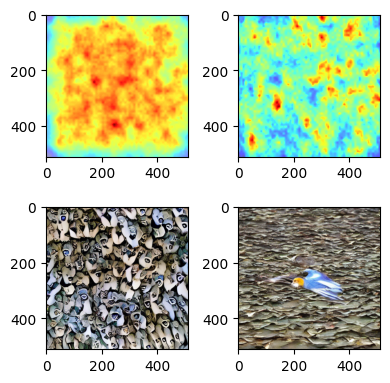

In [27]:
print(Trigger_ids.detach().cpu())
print(tri_embedding)
# print(Trigger_ids.shape)
Trigger_ids_end = Trigger_ids.detach()

prompt1_ebd = encode_text("cat walk on the street", device, tokenizer, text_encoder) # normal embd

ids1 = tokenizer("cat walk on the street", padding=padding, return_tensors="pt").to(device)
# tri_prompt1 = torch.cat((Trigger_ids_end, prompt1_ebd), dim=1) 
# prompt1 = torch.cat((prompt1_ebd[:, :1, :], Trigger_ids_end, prompt1_ebd[:, 1:, :]), dim=1) 

prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids_end,text_inputs=ids1["input_ids"])[0]

# prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][:4].to(device))[0]


with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(prompt1[0]).squeeze().cpu()[1]#(512，512)
    attention_maps3 = attention_maps3.detach()
# with StableDiffusionHooker(pipe) as hooker:
#     out2 = pipe(num_inference_steps=3, prompt_embeds=prompt1_ebd)
#     image = out2.images[0]
#     ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator3(prompt1[0]).squeeze().cpu()[2]
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
# ax1.imshow(image)/
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
L1_none = nn.L1Loss(reduction='none')
L1_mean = nn.L1Loss(reduction='mean')
L1_sum = nn.L1Loss(reduction='sum')
tri_embedding = encode_text("sks", device, tokenizer, text_encoder)
print("sks embedding")
print(tri_embedding.shape)
print("after training")
print(Trigger_ids_end.shape)
cosine_sim = torch.nn.functional.cosine_similarity(Trigger_ids_end, tri_embedding,dim=2)
# print(cosine_sim.shape)
print(" cos simi(ori_trigger, train_trigger) = ")
print(cosine_sim)

# 计算欧氏距离
cos1 = torch.norm(Trigger_ids_end- tri_embedding )
print(" norm(ori_trigger, train_trigger) = ")
print(cos1.item())

# 计算曼哈顿距离
cos2 = torch.abs(Trigger_ids_end- tri_embedding ).sum()
print(" sum(abs(ori_trigger, train_trigger) = ")
print(cos2.item())


In [ ]:
loss_sum = []

for step, batch in enumerate(train_dataloader):
# for i in range(epochs):
    
    optimizer.zero_grad()
    set_seed(1234)
    text1 = "A cat stand on a car"
    text2 = "A bird fly over building"
    ids1 = tokenizer(text1, padding=padding, return_tensors="pt").to(device)
    prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,input_ids=ids1)[0]

    ids2 = tokenizer(text2, padding=padding, return_tensors="pt").to(device)
    prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,input_ids=ids2)[0]


    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        
        atmp1 = hooker1.get_self_attention_map()
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(Trigger_ids[0]).squeeze().cpu()[1]#(512，512)
        
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        atmp2 = hooker2.get_self_attention_map()
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(Trigger_ids[0]).squeeze().cpu()[1]#(512,512)
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    # loss = loss_fn(normalize(atmp1), normalize(atmp2))
    # print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if(loss>0.2):
    #     epochs=epochs+1
print("=============Finish=============")
print("loss")
for num in loss_sum:
    print(num)